# Liver Segmentation 2D

Python version: 3.4.3 (Anaconda 2.4.1)  
IPython version: 4.0.1  
SimpleITK version: 0.9.0-g45317  
Operating system: OS X El Capitan v10.11.2

In [1]:
import collections

In [2]:
import matplotlib

In [3]:
matplotlib.use('Agg')

In [258]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt

In [6]:
import numpy as np

In [7]:
import os

In [8]:
import pickle

In [9]:
import scipy.stats

In [10]:
import SimpleITK as sitk

In [11]:
from os.path import expanduser, join

In [12]:
from scipy.spatial.distance import euclidean

---

## Image Display Functions

Classes and functions to be used later in displaying images are collected here.

In [13]:
def show_img(img, imgover=None):
    """Displays SimpleITK 2D image from its array. Includes a function to report 
    the pixel value under the mouse cursor. Option to display image overlay."""
    X = sitk.GetArrayFromImage(img)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    def format_coord(x, y):
        col = int(x + 0.5)
        row = int(y + 0.5)
        if col>=0 and col<numcols and row>=0 and row<numrows:
            z = X[row, col]
            return 'x=%1.4f, y=%1.4f, z=%1.4f' %(x, y, z)
        else:
            return 'x=%1.4f, y=%1.4f' %(x, y)

    if imgover is not None:
        X2 = sitk.GetArrayFromImage(imgover)
        maskVal = scipy.stats.mode(X2.flatten())[0][0]
        Xmask = np.ma.masked_where(X2 == maskVal, X2)
        im = ax.imshow(X, cmap=plt.cm.Greys_r)
        imOver = ax.imshow(Xmask, alpha=0.5)
    else:
        numrows, numcols = X.shape
        ax.imshow(X, cmap=plt.cm.Greys_r)
        ax.format_coord = format_coord
    
    plt.show()

In [14]:
def input_level_set_click(featImg, coords):
    RADIUS = 10
    numCols = featImg.GetSize()[0]
    numRows = featImg.GetSize()[1]
    X = np.zeros((numRows, numCols), dtype=np.int)
    
    for pt in coords:
        rowIni, rowEnd = pt[1] - RADIUS, pt[1] + RADIUS
        colIni, colEnd = pt[0] - RADIUS, pt[0] + RADIUS
        for i in range(rowIni, rowEnd+1):
            for j in range(colIni, colEnd+1):
                if euclidean((i,j), (pt[1], pt[0])) <= RADIUS:
                    X[i,j] = 1
    
    img = sitk.Cast(sitk.GetImageFromArray(X), featImg.GetPixelIDValue()) * -1 + 0.5
    img.SetSpacing(featImg.GetSpacing())
    img.SetOrigin(featImg.GetOrigin())
    img.SetDirection(featImg.GetDirection())
    
    return img

In [15]:
class IndexMouseCapture(object):
    def __init__(self, ax, X):
        self.ax = ax
        self.X = X
        self.coords = list()
        
        self.im = ax.imshow(self.X, cmap=plt.cm.Greys_r)
        self.im.axes.figure.canvas.draw()

    def onclick(self, event):
        ix, iy = int(round(event.xdata)), int(round(event.ydata))
        self.coords.append((ix, iy))
        circ = plt.Circle((ix, iy), 10, color='b')
        plt.gcf().gca().add_artist(circ)
        self.im.axes.figure.canvas.draw()

---

## I. Read in DICOM Images

The case being analyzed here is a resectable hepatocellular carcinoma from [The Cancer Imaging Archive](http://www.cancerimagingarchive.net). The patient ID is TCGA-BC-4073. Ultimately, the liver along with the tumor and blood vessels are to be reconstructed. Here, the focus is only on the liver.

Read in the DICOM series:

In [16]:
dicomPath = join(expanduser('~'), 'Documents', 'SlicerDICOMDatabase', 'TCIALocal', '0', 'images', '')
reader = sitk.ImageSeriesReader()
seriesIDread = reader.GetGDCMSeriesIDs(dicomPath)[1]
dicomFilenames = reader.GetGDCMSeriesFileNames(dicomPath, seriesIDread)
reader.SetFileNames(dicomFilenames)
imgSeries = reader.Execute()

Pick a slice to work with. Only the 2D case is considered here.

In [226]:
sliceNum = 42

In [227]:
imgSlice = imgSeries[:,:,sliceNum]

Note that the TCGA-BC-4073 patient has 2 series of images (series 9 & 10). The series IDs are:

In [17]:
reader.GetGDCMSeriesIDs(dicomPath)

('1.3.6.1.4.1.14519.5.2.1.8421.4008.138804327531308458796105931925',
 '1.3.6.1.4.1.14519.5.2.1.8421.4008.409273914557307131521893097931')

The 2<sup>nd</sup> tuple element corresponds to series 9.

Display the slice:

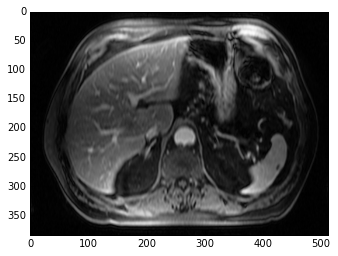

In [228]:
show_img(imgSlice)

## II. Filtering

First, the original image is smoothed with an edge-preserving filter. Two options for filtering are used here: either curvature anisotropic diffusion or mean filtering. 

### Curvature anisotropic diffusion

In [229]:
timeStep_, conduct, numIter = (0.04, 9.0, 5)
imgRecast = sitk.Cast(imgSlice, sitk.sitkFloat32)
curvDiff = sitk.CurvatureAnisotropicDiffusionImageFilter()
curvDiff.SetTimeStep(timeStep_)
curvDiff.SetConductanceParameter(conduct)
curvDiff.SetNumberOfIterations(numIter)
imgFilter = curvDiff.Execute(imgRecast)

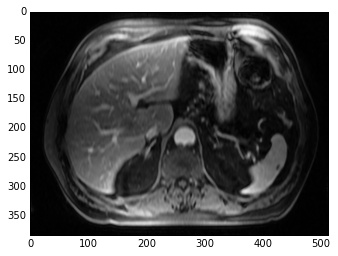

In [230]:
show_img(imgFilter)

### Mean filtering

In [150]:
imgFilter = sitk.Mean(image1=imgSlice, radius=(3,3))

In [130]:
show_img(imgFilter)

## III. Edge Potential

### Gradient magnitude recursive Gaussian

In [239]:
sigma_ = 1.0
imgGauss = sitk.GradientMagnitudeRecursiveGaussian(image1=imgFilter, sigma=sigma_)

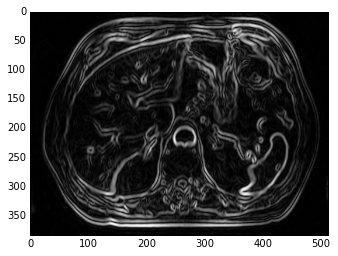

In [246]:
show_img(imgGauss)

## IV. Feature Image

### Sigmoid mapping

Following Section 4.3.1 "Fast Marching Segmentation" on pages 373-374 from **The ITK Software Guide Book 2: Design and Functionality, 4<sup>th</sup> ed.** for the setup of the sigmoid filter. The output will be passed along to a segmentation algorithm below. 

Note that the plan is to conduct multiple rounds of segmentation, to "start with a downsampled volume and work back to the full resolution using the results at each intermediate scale as the initialization for the next scale." (pg. 370) Therefore, K1 and K2 below for the sigmoid mapping are first set loosely set and will become more strict in later segmentations. 

In [240]:
K1, K2 = 10.0, 4.0

In [241]:
alpha_ = (K2 - K1)/6
beta_ = (K1 + K2)/2

sigFilt = sitk.SigmoidImageFilter()
sigFilt.SetAlpha(alpha_)
sigFilt.SetBeta(beta_)
sigFilt.SetOutputMaximum(1.0)
sigFilt.SetOutputMinimum(0.0)
imgSigmoid = sigFilt.Execute(imgGauss)

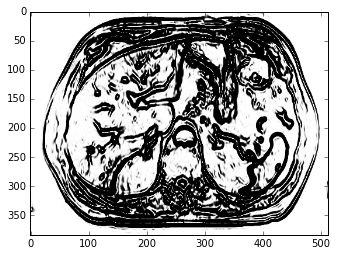

In [247]:
show_img(imgSigmoid)

## V. Input Level Set

Using ideas from the SimpleITK [geodesic active contour example](http://www.itk.org/SimpleITKDoxygen/html/GeodesicActiceContourSegmentation_8py-example.html) to create an initial input level set. Instead of computing a signed Maurer distance map and then applying a binary threshold, the approach here simply draws a circle of a given radius around each user-chosen seed coordinate. Following the SimpleITK Notebook on [Levelset Segmentation](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/31_Levelset_Segmentation.html), a binary dilation with a kernel size of 3 is performed. Finally, as was done in the [example](http://www.itk.org/SimpleITKDoxygen/html/GeodesicActiceContourSegmentation_8py-example.html) (line 60), all image values are multiplied by -1 and added to 0.5. The results is the input level set.

Use the class *IndexMouseCapture* (defined above) to capture coordinates from mouse clicks for seeds. The radii are all assumed to be of the same size at the moment.

In [48]:
X = sitk.GetArrayFromImage(imgSigmoid)

fig = plt.figure()
ax = fig.add_subplot(111)
capture = IndexMouseCapture(ax, X)
fig.canvas.mpl_connect('button_press_event', capture.onclick)

6

In [242]:
coords = pickle.load(open(os.path.join('Liver Segmentation Data', 'TCGA-BC-4073', 'slice42_2nd_round_seeds.p'), 'rb'))

In [243]:
initImg = input_level_set_click(imgSigmoid, coords)

In [32]:
pickleDir = os.path.join('Liver Segmentation Data', 'TCGA-BC-4073', '')

In [33]:
pickle.dump(capture.coords, open(pickleDir + 'slice51_1st_round_seeds.p', 'wb'))

For subsequent rounds, create a new level set from segmentation of downsampled image. Start by converting the segmentation result into a workable format:

In [238]:
binaryThresh = sitk.BinaryThresholdImageFilter()
binaryThresh.SetLowerThreshold(-3.0)
binaryThresh.SetUpperThreshold(2.0)
binaryThresh.SetInsideValue(1)
binaryThresh.SetOutsideValue(0)
binaryImg = binaryThresh.Execute(imgGac)

In [228]:
show_img(binaryImg)

Add in new seeds using *IndexMouseCapture* above, and then create a new input level set image:

In [244]:
# get array from previous geodesic active contour
X_gac = sitk.GetArrayFromImage(binaryImg)

# get array from user-input seed clicks
X_click = sitk.GetArrayFromImage(input_level_set_click(imgSigmoid, coords))
X_click[np.where(X_click == -0.5)] = 1.0
X_click[np.where(X_click == 0.5)] = 0.0

# combine into a single array
X_input = X_gac.astype(bool) + X_click.astype(bool)

# write array into new input level set
initImg = sitk.Cast(sitk.GetImageFromArray(X_input.astype(int)), imgSigmoid.GetPixelIDValue()) * -1 + 0.5
initImg.SetSpacing(imgSigmoid.GetSpacing())
initImg.SetOrigin(imgSigmoid.GetOrigin())
initImg.SetDirection(imgSigmoid.GetDirection())

### Import manual initial level set

If desired, import an initial level set drawn close to boundaries of liver in 3D Slicer. All values inside the set are equal to 1, while any outside values are zero. 

In [187]:
manInLS = sitk.ReadImage(os.path.join('Liver Segmentation Data', 'TCGA-BC-4073', 
                                          'slice44_initial_level_set.nrrd'))
X_man = sitk.GetArrayFromImage(manInLS[:,:,44])

Create initial level set image for input into segmentation:

In [188]:
initImg = sitk.Cast(sitk.GetImageFromArray(X_man), imgSigmoid.GetPixelIDValue()) * -1 + 0.5
initImg.CopyInformation(imgSigmoid)

Display the initial input level set:

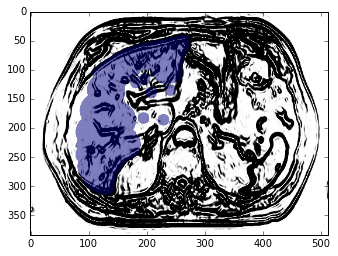

In [248]:
show_img(imgSigmoid, initImg)

## VI. Segmentation

### Geodesic active contour

In [236]:
gac = sitk.GeodesicActiveContourLevelSetImageFilter()
gac.SetPropagationScaling(1.0)
gac.SetCurvatureScaling(0.2)
gac.SetAdvectionScaling(4.0)
gac.SetMaximumRMSError(0.01)
gac.SetNumberOfIterations(200)

<SimpleITK.SimpleITK.GeodesicActiveContourLevelSetImageFilter; proxy of <Swig Object of type 'itk::simple::GeodesicActiveContourLevelSetImageFilter::Self *' at 0x12412d810> >

In [245]:
imgGac = gac.Execute(initImg, imgSigmoid)

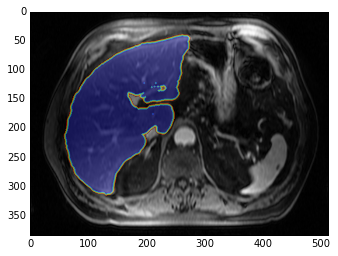

In [250]:
show_img(imgSlice, imgGac)

### Import manual label map

If desired, import a manual segmentation from 3D Slicer instead. 

In [202]:
manLabelMap = sitk.ReadImage(os.path.join('Liver Segmentation Data', 'TCGA-BC-4073', 
                                          'slice50_partial_manual.nrrd'))
X_man = sitk.GetArrayFromImage(manLabelMap[:,:,50])

In [165]:
manLabelMap.GetSize()

(512, 384, 72)

In [1080]:
show_img(manLabelMap[:,:,48])

If needed, combine manual label map with segmentation from above:

In [252]:
X_gac = sitk.GetArrayFromImage(imgGac)

In [212]:
X_bool = X_gac < np.amax(X_gac)
X_final = X_man.astype(bool) + X_bool
X_final = X_final.astype(int)

In [216]:
show_img(imgSlice, sitk.GetImageFromArray(X_final))

### Fill in holes

If necessary, fill in holes in the segmentation.

In [209]:
X_gac = sitk.GetArrayFromImage(imgGac)

In [255]:
plt.imshow(X_gac)
plt.show()

In [256]:
X_gac[125:140,216:238] = 1

## VII. Write out to file

If needed, binarize segmentation image:

In [196]:
X_gac = sitk.GetArrayFromImage(imgGac)

In [257]:
X_bool = X_gac < np.amax(X_gac)
X_final = X_bool.astype(int)

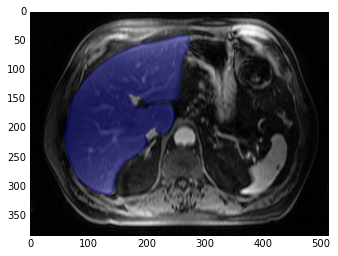

In [259]:
show_img(imgSlice, sitk.GetImageFromArray(X_final))

Save array representation of segmented image in NumPy format:

In [221]:
np.save(os.path.join('Liver Segmentation Data', 'TCGA-BC-4073', 'slice50'), X_final)